In [1]:
import numpy as np
import tensorflow as tf
import torch

from tensorflow import keras
from tensorflow.keras import layers


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [2]:
def get_dataset(take_first=None):
    fashion_mnist = keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    train_images = train_images / 255.0
    test_images = test_images / 255.0

    if take_first is not None:
        train_images = train_images[:take_first, ...]
        train_labels = train_labels[:take_first, ...]
        
    train_images = np.expand_dims(train_images, -1)
    test_images = np.expand_dims(test_images, -1)
        
    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = get_dataset()

In [4]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
)


In [5]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.fit(train_images,
          train_labels,
          epochs=1)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples
60000/60000 [==============================] - 3s 42us/sample - loss: 0.6057 - acc: 0.7958
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [6]:
for layer in model.layers:
    for t in layer.get_weights():
        print(t.shape)

(784, 10)
(10,)


In [8]:
for layer in model.layers:
    for t in layer.get_weights():
        print(t)

[[-0.05207232 -0.06053626 -0.088627   ...  0.04087169  0.00027399
  -0.03533357]
 [-0.00525151 -0.10244952 -0.03475771 ... -0.10097712 -0.06813363
   0.02764581]
 [-0.01187083 -0.1721745   0.00821813 ... -0.10540718 -0.0481778
  -0.15599594]
 ...
 [-0.21938357 -0.08349083  0.03218159 ... -0.17229213 -0.219569
  -0.079087  ]
 [-0.25232586 -0.1365683   0.06303443 ... -0.09119022 -0.15364283
   0.1139854 ]
 [-0.11826022 -0.12643188 -0.00184077 ... -0.04861708 -0.07183063
  -0.026675  ]]
[ 0.04497597 -0.12922743 -0.06494667  0.05529986 -0.25363752  0.6366494
  0.15206626 -0.08180395 -0.24729791 -0.4335048 ]


In [9]:
print('Evaluate source model')
test_loss, test_acc = model.evaluate(test_images,
                                     test_labels,
                                     verbose=0)
print('Test accuracy:', test_acc)

Evaluate source model
Test accuracy: 0.8216


In [10]:
def to_tf_kernel_order(tensor):
    """Change conv.kernel axis order from PyTorch to Tensoflow.

    :param tensor: tensor with conv.kernel weights.
    :return: tensor with the Tensoflow-like exis order.
    []
    """
    return np.transpose(tensor, (2, 3, 1, 0))


def to_pytorch_kernel_order(tensor):
    """Change conv.kernel axis order from Tensoflow to PyTorch.

    :param tensor: tensor with conv.kernel weights.
    :return: tensor with the Pytorch-like exis order.
    []
    """
    return tensor.T

In [11]:
result = np.max(tf.keras.backend.get_value(model.layers[0](test_images.astype(np.float32))), 1)

In [12]:
result.shape

(10000,)

In [13]:
import torch.nn as nn

In [14]:
torch_model = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(7850, 10),
                            nn.Softmax(dim=1)
                           )

In [16]:
dense, dense_bias = model.layers[-1].get_weights()

In [20]:
torch_model[-2].weight.data = torch.from_numpy(dense.T).float()
torch_model[-2].bias.data = torch.from_numpy(dense_bias).float()

In [28]:
# [batch, h, w, c] -> [batch, c, h, w]
torch_test_images = np.transpose(test_images, (0, 3, 1, 2))

outputs = np.argmax(torch_model(torch.from_numpy(torch_test_images).float()).data.numpy(), 1)
c = (outputs == test_labels).squeeze()

print("Accuracy:", np.sum(c.astype(np.int))/c.shape[0])

Accuracy: 0.8216


In [47]:
tf_outputs = np.argmax(tf.keras.backend.get_value(model(test_images.reshape((test_images.shape[0], -1)))), 1) == test_labels
print("Accuracy:", np.sum(tf_outputs.astype(np.int))/tf_outputs.shape[0])

Accuracy: 0.8216


In [50]:
np.argmax(tf.keras.backend.get_value(model(test_images.reshape((test_images.shape[0], -1)))), 1)

array([9, 2, 1, ..., 8, 1, 5])

In [51]:
outputs

array([9, 2, 1, ..., 8, 1, 5])

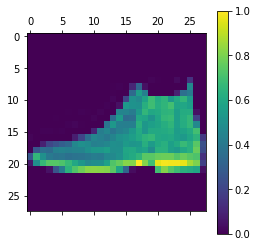

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.matshow(test_images[0, ...].reshape((28, 28)))
plt.colorbar()
plt.show()

In [53]:
torch_test_images = np.transpose(test_images, (0, 3, 1, 2))

# for idx in range(10):
tf_tensor = tf.keras.backend.get_value(model(test_images.reshape((test_images.shape[0], -1))))
torch_answer = torch_model(torch.from_numpy(torch_test_images).float()).data.numpy()
print(np.linalg.norm(tf_tensor-torch_answer))
print("================")

2.070092e-05


In [54]:
torch_weight = torch_model[-2].weight.data
tf_weight = model.layers[-1].get_weights()[0]

In [55]:
np.linalg.norm(tf_weight - torch_weight.data.numpy().T)

0.0